# Natural Language processing (NLP)

Political Bias Detection with our dataset defined with Rationnal wiki and Conservpedia

"Biased left" = 0, "Neutral" = 1, "Biased right" = 2

The training set only contain left and right biased text, a threshold will be applied on the test set to define Neutral text

## Importing Libraries

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

#NLP libraries
import nltk
from gensim.models import Doc2Vec
import gensim
from gensim.models.doc2vec import TaggedDocument
import urllib

#Machine learning libraries
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#Helper libraries
import multiprocessing
import numpy as np
import pandas as pd
import math
from bs4 import BeautifulSoup
import re
import os


nltk.download('punkt', download_dir="./data_model/")
nltk.download("stopwords", download_dir="./data_model/")
nltk.data.path.append(os.path.abspath("./data_model/"))

[nltk_data] Downloading package punkt to ./data_model/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ./data_model/...
[nltk_data]   Package stopwords is already up-to-date!


## Importing All the data : 
- Training data : Rationnal wiki (biased left) and Conservpedia (biased right)
- Test data : Wikispeedia pages that we want to predict the bias
- Verification data : Dataset of university of Zurich that treat bias with text

In [131]:
#Training data
train_data_0=pd.read_csv("./scraped_data/rationalwiki_articles.csv")
train_data_0["text_content"]=train_data_0["text_content"].replace({r"\r\n" : " ", "\n": " "},regex=True)
train_data_0["bias"]=0

train_data_2=pd.read_csv("./scraped_data/infogalactic_articles.csv")
train_data_2["text_content"]=train_data_2["text_content"].replace({r"\r\n" : " ", "\n": " "},regex=True)
train_data_2["bias"]=2

train_data=pd.concat([train_data_0,train_data_2], ignore_index=True)



#Test data
text_file_dir="./data/wikispeedia_articles_plaintext/plaintext_articles/"
file_data=[]

for filename in os.listdir(text_file_dir):
    with open(os.path.join(text_file_dir, filename), "r") as file:
        content = file.read()
    
        # Split the content into lines to remove the header
    lines = content.split('\n')

    #Removing the header (line 0)
    if lines:
        lines.pop(0)

    # Making it an array and removing all \n
    content = '\n'.join(lines)
    content = content.replace("\n", " ")

    filename_fin=filename[:-4]
    new_file_content= {"text_content": content, "title": urllib.parse.unquote(filename_fin , encoding = 'utf-8')}
    
    file_data.append(new_file_content)

test_data = pd.DataFrame(file_data)

#Verification Data
verif_data= pd.read_csv("./data_model/labeled_dataset_english.csv", header=0, usecols=["Label_bias", "article", "type"])

verif_data["type"]=verif_data["type"].replace(['left','center','right'],[0,1,2])

verif_data=verif_data.rename(columns={"type": "orientation", "article": "text_content", "Label_bias": "bias"})

verif_data = verif_data.dropna()



#WHEN FINAL REMOVE THIS

train_data=verif_data.copy().drop(columns="bias").rename(columns={"orientation": "bias"})
train_data=train_data[train_data["bias"] !=1]

### Verification on the data

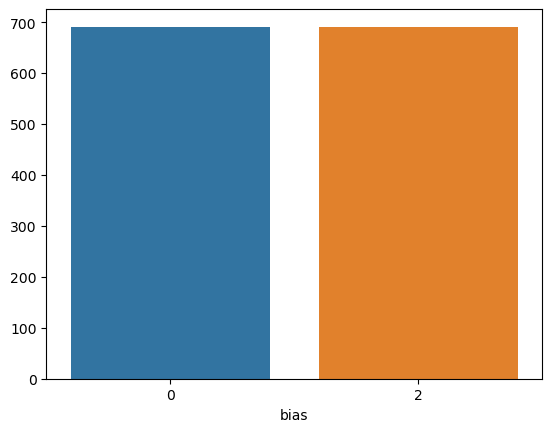

In [132]:
bias_vals = train_data['bias'].value_counts()
plt.figure()
sns.barplot(x=bias_vals.index, y=bias_vals.values)
plt.show()

## Preprocessing All Dataset

### Cleaning and removing non necessary words

english _stop words


In [133]:
_stopwords = nltk.corpus.stopwords.words("english")

Cleaning dataset:


In [134]:
def clean(text):  #Removing unecessary punctuation and all lower case.
    text = re.sub(r'\|\|\|', r' ', text) 
    text = text.replace('„','')
    text = text.replace('“','')
    text = text.replace('"','')
    text = text.replace('\'','')
    text = text.replace('-','')

    for i in range(330):
        text= text.replace(f"[{i}]","")

    text = text.lower()
    return text

def remove_stopwords(content): #Removing stopwords that are not needed for NLP
    for word in _stopwords:
        content = content.replace(' '+word+' ',' ')
    return content

#train_data
train_data['text_content'] = train_data['text_content'].apply(clean)
train_data['text_content'] = train_data['text_content'].apply(remove_stopwords)

#test_data
test_data['text_content'] = test_data['text_content'].apply(clean)
test_data['text_content'] = test_data['text_content'].apply(remove_stopwords)

#verif_data
verif_data['text_content'] = verif_data['text_content'].apply(clean)
verif_data['text_content'] = verif_data['text_content'].apply(remove_stopwords)

### Creating balanced train set (if already balanced : no valid_train dataset)

In [135]:
np.random.seed=10
length = [len(train_data[train_data["bias"] == i]) for i in [0,2]] #Define if a class is underpresented
a=np.min(length)

# Select rows for each class and combine them
indices = []

for bias_class in [0, 2]:
    indices.extend(train_data[train_data["bias"] == bias_class].index[:a])

# Create the training dataset
train = train_data.loc[indices[:]]
train = train.iloc[np.random.permutation(len(train))]
train["bias"].value_counts()

bias
0    691
2    691
Name: count, dtype: int64

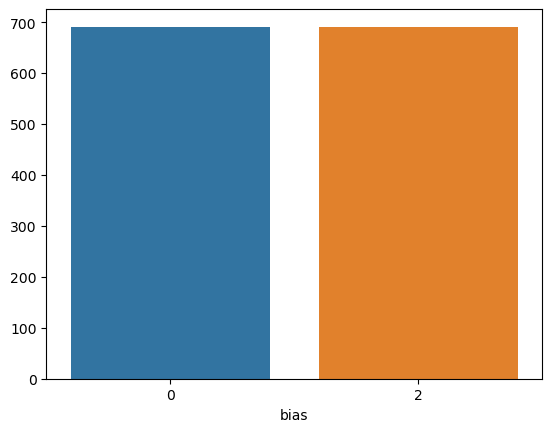

In [136]:
bias_vals = train['bias'].value_counts()
plt.figure()
sns.barplot(x=bias_vals.index, y=bias_vals.values)
plt.show()

### creating the train data and validation train data

In [137]:
split_index=int(len(train)*0.8)
valid_train=train.iloc[split_index:]
train=train.iloc[:split_index]


In [138]:
train["bias"].value_counts()

bias
0    553
2    552
Name: count, dtype: int64

### Tokenize the text content of all dataset

In [139]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 3:
                continue
            tokens.append(word.lower())
    return tokens


#Train dataset
train_tagged = train.apply(
   lambda r: TaggedDocument(words=tokenize_text(r['text_content']), tags=  [r.bias]), axis=1)

valid_train_tagged = valid_train.apply(
   lambda r: TaggedDocument(words=tokenize_text(r['text_content']), tags=  [r.bias]), axis=1)

#Pred dataset
test_data_tagged = test_data.apply(
   lambda r: TaggedDocument(words=tokenize_text(r['text_content']), tags=[]), axis=1)

#Verification dataset
verif_data_tagged = verif_data.apply(
   lambda r: TaggedDocument(words=tokenize_text(r['text_content']), tags=[r.orientation]), axis=1)

## Vectorizing each document from the data
(May take some times: up to 15 mins, we use the Distributed bag of word D-BOW)

Elements in Doc2Vec :

vector_size (int): Dimensionality of the feature vectors. This is the size of the vectors that represent each document.

window (int): Maximum distance between the current and predicted word within a sentence. It influences the context window for word prediction.

min_count (int): Ignores all words with a total frequency lower than this.

workers (int): Number of CPU cores to use when training the model. Parallelization speeds up training.

epochs (int): Number of iterations (epochs) over the corpus during training. This parameter controls how many times the model iterates over the entire dataset.

dm (int, {1, 0}): Defines the training algorithm. If dm=1, the PV-DM (Distributed Memory) model is used. If dm=0, the PV-DBOW (Distributed Bag of Words) model is used.

dbow_words (int, {1, 0}): If set to 1, trains word vectors as well as document vectors. This is only effective when using the PV-DBOW model.

dm_concat (int, {1, 0}): If set to 1, concatenates paragraph vectors rather than averaging them in the PV-DM model.

dm_tag_count (int): Expected constant number of document tags per document during training.

hs (int, {1, 0}): If set to 1, hierarchical softmax will be used for model training.

negative (int): If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drawn (usually between 5-20).

### Initialize model and training it on the train dataset

In [146]:
cores = multiprocessing.cpu_count()
model = Doc2Vec(dm=0, vector_size=400, negative=5, hs=0, sample=0, min_count=0, workers=cores, epochs=50) # dm=0 --> PV-DBOW

model.build_vocab(train_tagged.values)  #The model builds his vocabulary on the training set
model.train(utils.shuffle(train_tagged.values), #model train on a mixed trained values and 50 steps
    total_examples=len(train_tagged.values),epochs=model.epochs)  


### Using trained model to learn to return document vectors and labels

In [147]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    classes, features = zip(*[(doc.tags[0],
      model.infer_vector(doc_words=doc.words, epochs=model.epochs)) for doc in sents]) #steps=epochs increase steps for better precision but more running time
    return features, classes


train_x, train_y= vec_for_learning(model, train_tagged) #Train data
test_train_x, test_train_y= vec_for_learning(model, valid_train_tagged) #test train data
verif_x, verif_y = vec_for_learning(model, verif_data_tagged) # Verif data

## Classification methods : We use Support Vector Machine for Classification (SVM-C)

In [142]:
#Helper function for calculating accuracy on the test set.
def acc(true, pred):
  acc = 0
  for x,y in zip(true,pred):
    if(x == y): acc += 1
  return acc/len(pred)

### Creating the classifier model and cross validation

In [148]:

"""
svc = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],            # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'degree': [2, 3, 4],               # Degree of the polynomial kernel (if kernel is 'poly')
    'gamma': ['scale', 'auto', 0.1, 1],  # Kernel coefficient for 'rbf' and 'poly'
    'coef0': [0.0, 1.0],   
}

grid_search=GridSearchCV(svc, param_grid, cv=10, scoring="accuracy")

grid_search.fit(train_x, train_y)
best_param= grid_search.best_params_
"""
svc=SVC()
param_grid = {'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.1, 1],
    }
    
grid_search=GridSearchCV(svc, param_grid, cv=5, scoring="accuracy")

grid_search.fit(train_x, train_y)
best_param= grid_search.best_params_#{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'} for zurich
#best_param={'C': 0.1, 'coef0': 1.0, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'} # for long text
svc =SVC(**best_param, probability=True)
#svc=SVC(probability=True)
svc.fit(train_x,train_y)

print("Accuracy of the model trained = %0.2f %%"%(acc(train_y,svc.predict(train_x))*100)) #Accuracy of model depending on the fitting
print("Accuracy of the model with test train data = %0.2f %%"%(acc(test_train_y,svc.predict(test_train_x))*100)) #Accuracy of the model on verifying data

Accuracy of the model trained = 99.73 %
Accuracy of the model with test train data = 83.03 %


In [88]:
best_param
#{'C': 0.1, 'coef0': 1.0, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}

{'C': 0.1, 'coef0': 1.0, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}

In [108]:
print("Accuracy of the model with verification data = %0.2f %%"%(acc(verif_y,svc.predict(verif_x))*100)) #Accuracy of the model on verifying data

Accuracy of the model with verification data = 46.31 %


### Vectorizing the test data (using D-BOW model)

In [83]:
def vectorizing_project_data(model, tagged_docs):
    sents = tagged_docs.values
    features = [model.infer_vector(doc.words, epochs=model.epochs) for doc in sents]
    return features

test_x = vectorizing_project_data(model, test_data_tagged)

### Prediction of Classes on the Test Set

In [84]:
class_probabilities=svc.predict_proba(test_x)
test_labels=[]
threshold=0.49

for i in range(len(class_probabilities)):
    if class_probabilities[i,0]>threshold and class_probabilities[i,0]<1-threshold:# [0,4-0,6]
        label=1
    else: 
        label=np.argmax(class_probabilities[i,:])
        if label==1:
            label=2
    test_labels.append(label)

test_data["Bias"] = test_labels
test_data["Bias"].value_counts()

Bias
0    2318
2    1218
1    1068
Name: count, dtype: int64

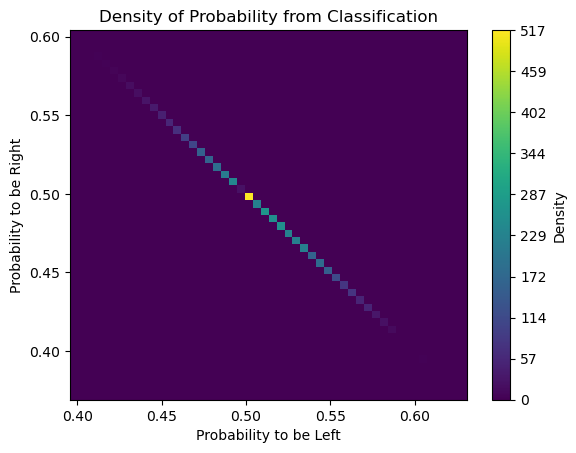

In [109]:
plt.figure()

#density plot
hist, xedges, yedges = np.histogram2d(class_probabilities[:, 0], class_probabilities[:, 1], bins=(50, 50))

#Colorbar
plt.pcolormesh(xedges, yedges, hist.T, cmap="viridis") #color-blind friendly

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Density')

# Set labels and title
plt.xlabel("Probability to be Left")
plt.ylabel("Probability to be Right")
plt.title("Density of Probability from Classification")

# Display legend with colorbar values
legend_values = np.linspace(hist.min(), hist.max(), num=10)  
cbar.set_ticks(legend_values)
cbar.set_ticklabels([f'{int(value)}' for value in legend_values])

# Show the plot
plt.show()

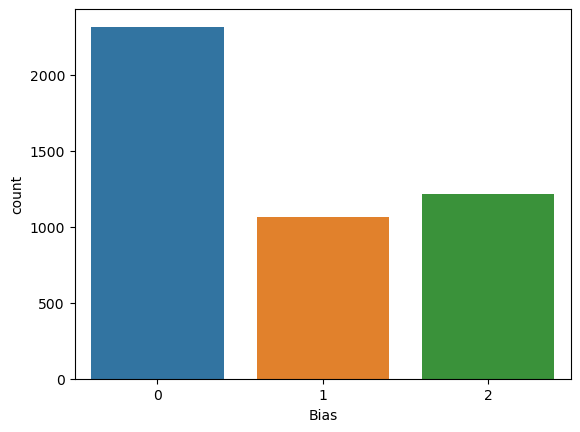

In [86]:
plt.figure()
sns.barplot(x=test_data["Bias"].value_counts().index, y=test_data["Bias"].value_counts())
plt.show()

In [110]:
test_data[test_data["title"]=="Portuguese_Communist_Party"]

,text_content,title,Bias
3319,portuguese communist party 2007 schools wiki...,Portuguese_Communist_Party,1


In [123]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer


model2=BernoulliNB()
model2.fit(train_x, train_y)
print(acc(train_y,model2.predict(train_x)))
print(acc(test_train_y, model2.predict(test_train_x)))

0.6018518518518519
0.19262295081967212
